In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [12]:
import os, shutil
from sklearn.model_selection import train_test_split

original_data_dir = 'state-farm-distracted-driver-detection/imgs/train'
output_base_dir = 'imgs_split'  # New root directory

# Target dirs
train_dir = os.path.join(output_base_dir, 'train')
val_dir = os.path.join(output_base_dir, 'val')
test_dir = os.path.join(output_base_dir, 'test')

# Create folders
for target_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(target_dir, exist_ok=True)
    for i in range(10):  # c0 to c9
        os.makedirs(os.path.join(target_dir, f'c{i}'), exist_ok=True)

# Process each class
for class_name in os.listdir(original_data_dir):
    class_path = os.path.join(original_data_dir, class_name)
    images = os.listdir(class_path)

    train_files, temp_files = train_test_split(images, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    for dataset, files in zip([train_dir, val_dir, test_dir], [train_files, val_files, test_files]):
        for fname in files:
            src = os.path.join(class_path, fname)
            dst = os.path.join(dataset, class_name, fname)
            shutil.copyfile(src, dst)

print("Dataset split into train/val/test successfully!")


Dataset split into train/val/test successfully!


In [13]:
base_dir = r"C:\Users\vishnu vardhan\OneDrive\Desktop\IITM ACADS\Drowsiness Detection\imgs_split"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

In [14]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 10


In [16]:
# ✅ 1. Image Preprocessing & Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,  # Rotate images randomly
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale, no augmentation
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale


In [17]:
# Create Image Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False  # Important! Do not shuffle test set
)

Found 15692 images belonging to 10 classes.
Found 3364 images belonging to 10 classes.
Found 3368 images belonging to 10 classes.


In [18]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

NameError: name 'predicted_classes' is not defined

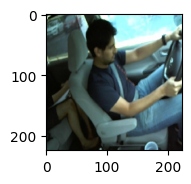

In [ ]:
#

# **Using Transfer Learning**


In [20]:
from tensorflow.keras.applications import MobileNetV2
#Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers (so they don’t get retrained)
base_model.trainable = False

In [21]:
# Define the new model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # 10 classes (c0 to c9)
])

In [22]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [23]:
# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=20, callbacks=[early_stopping])

Epoch 1/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 553s 1s/step - accuracy: 0.2227 - loss: 2.2311 - val_accuracy: 0.5919 - val_loss: 1.4069
Epoch 2/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 373s 760ms/step - accuracy: 0.4756 - loss: 1.5348 - val_accuracy: 0.6983 - val_loss: 1.0689
Epoch 3/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 281s 572ms/step - accuracy: 0.5845 - loss: 1.2306 - val_accuracy: 0.7652 - val_loss: 0.8660
Epoch 4/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 331s 675ms/step - accuracy: 0.6470 - loss: 1.0760 - val_accuracy: 0.7693 - val_loss: 0.7900
Epoch 5/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 275s 560ms/step - accuracy: 0.6837 - loss: 0.9551 - val_accuracy: 0.7869 - val_loss: 0.7149
Epoch 6/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 291s 593ms/step - accuracy: 0.7142 - loss: 0.8714 - val_accuracy: 0.7996 - val_loss: 0.6546
Epoch 7/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 289s 587ms/step - accuracy: 0.7349 - loss: 0.8043 - val_accuracy: 0.8294 - val_loss: 0.5842
Epoch 8/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 285s 580ms/step - accuracy: 0.7563 - lo

In [24]:
# Continue training after 10 epochs
history = model.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=30,  # Continue for additional epochs, e.g., 10 more
    initial_epoch=20,  # Start from epoch 10
    callbacks=[early_stopping]  # You can include the early stopping callback again
)


Epoch 21/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 240s 488ms/step - accuracy: 0.8418 - loss: 0.4787 - val_accuracy: 0.8936 - val_loss: 0.3373
Epoch 22/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 246s 501ms/step - accuracy: 0.8548 - loss: 0.4530 - val_accuracy: 0.8743 - val_loss: 0.3869
Epoch 23/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 592s 1s/step - accuracy: 0.8531 - loss: 0.4543 - val_accuracy: 0.8995 - val_loss: 0.3242
Epoch 24/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 735s 1s/step - accuracy: 0.8553 - loss: 0.4363 - val_accuracy: 0.8942 - val_loss: 0.3234
Epoch 25/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 665s 1s/step - accuracy: 0.8635 - loss: 0.4259 - val_accuracy: 0.8968 - val_loss: 0.3201
Epoch 26/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 244s 496ms/step - accuracy: 0.8714 - loss: 0.4109 - val_accuracy: 0.9016 - val_loss: 0.3063
Epoch 27/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 249s 508ms/step - accuracy: 0.8685 - loss: 0.4044 - val_accuracy: 0.8980 - val_loss: 0.3122
Epoch 28/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 254s 517ms/step - accuracy: 0.8709 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
Predicted class index: 0
Predicted label: c0


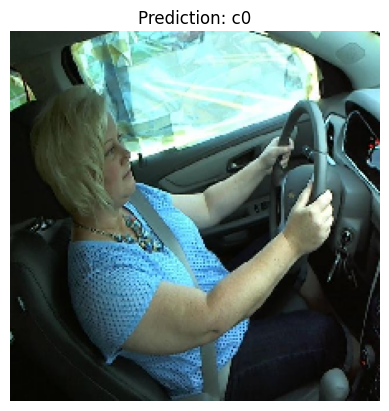

In [26]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# ✅ Path to your test image
img_path = "imgs_split/train/c0/img_100145.jpg"

# Load and preprocess
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Predict using your trained model
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]

# Get class names from validation generator
class_indices = val_generator.class_indices
labels = list(class_indices.keys())

print(f"Predicted class index: {predicted_class}")
print(f"Predicted label: {labels[predicted_class]}")

# Show the image
plt.imshow(img)
plt.title(f"Prediction: {labels[predicted_class]}")
plt.axis('off')
plt.show()


In [27]:
model.save("distracted_driver_model.h5")


In [28]:
# # Save the model
# model = load_model("/kaggle/input/modelcnn/distracted_driver_model1.h5")

In [29]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

106/106 ━━━━━━━━━━━━━━━━━━━━ 70s 668ms/step - accuracy: 0.9316 - loss: 0.2516
Test Accuracy: 0.9169


In [34]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)


106/106 ━━━━━━━━━━━━━━━━━━━━ 25s 222ms/step


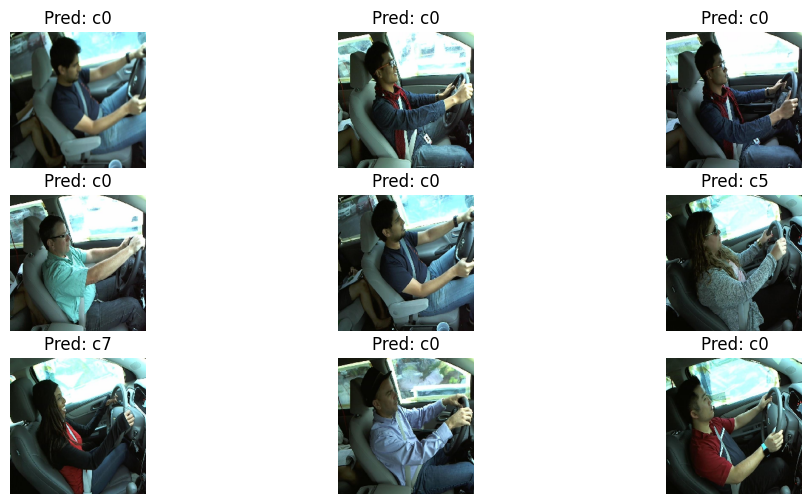

In [35]:
#  ✅ 8. Show Sample Predictions
class_labels = list(train_generator.class_indices.keys())  # Get class names

plt.figure(figsize=(12, 6))
for i in range(9):
    img, _ = test_generator[i]  # Get test batch
    plt.subplot(3, 3, i+1)
    plt.imshow(img[0])
    plt.title(f"Pred: {class_labels[predicted_classes[i]]}")
    plt.axis("off")

plt.show()

In [37]:
from sklearn.metrics import classification_report
import numpy as np

# Get predictions on the validation set
y_pred = model.predict(test_generator, verbose=1)

# Get the true labels (ground truth)
y_true = test_generator.classes
print(y_true)

# If your model outputs probabilities, you need to take the argmax to get the predicted class
y_pred_classes = np.argmax(y_pred, axis=-1)

# Print classification report
target_names = list(test_generator.class_indices.keys())  # c0 to c9
print(classification_report(y_true, y_pred_classes, target_names=target_names))


106/106 ━━━━━━━━━━━━━━━━━━━━ 23s 212ms/step
[0 0 0 ... 9 9 9]
              precision    recall  f1-score   support

          c0       0.89      0.91      0.90       374
          c1       0.84      0.99      0.91       341
          c2       0.97      0.91      0.94       348
          c3       0.91      0.96      0.93       352
          c4       0.94      0.95      0.95       349
          c5       0.96      0.98      0.97       347
          c6       0.96      0.87      0.91       349
          c7       0.87      0.98      0.92       301
          c8       0.93      0.76      0.83       287
          c9       0.94      0.86      0.89       320

    accuracy                           0.92      3368
   macro avg       0.92      0.91      0.91      3368
weighted avg       0.92      0.92      0.92      3368



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

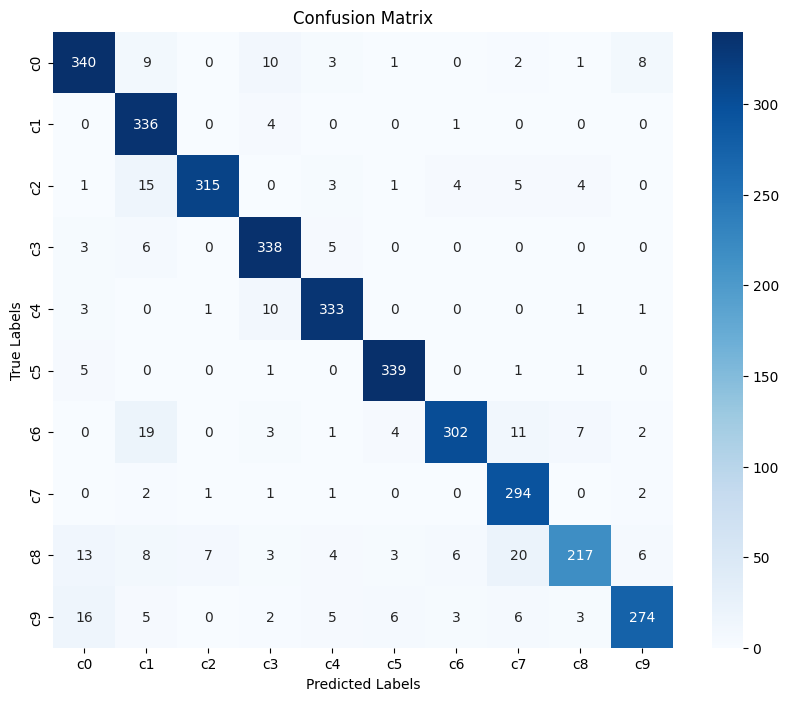

In [40]:
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Plot it
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()